## <b> Face Swap </b>

In this project, OpenCV and dlib will be utilised to extract the facial landmarks of people. We will use a pretrained model.

In [2]:
import cv2 as cv
import numpy as np
import dlib
import requests
from PIL import Image

We will then create a function to extract indices from a numpy array

In [3]:
def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index

Next we load our source image

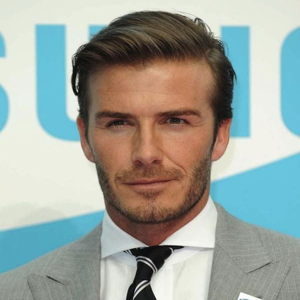

In [11]:
def load_image(img_path):
    if 'https' in img_path:
        response = requests.get(img_path, stream = True).raw
        image = Image.open(response)
    else:
        image = Image.open(img_path)
    return image

image1 = load_image('https://i.pinimg.com/originals/f9/50/51/f95051f5f25f1d8be9d3cda614cede90.jpg').resize((300,300))
image1

Next we load our destination image

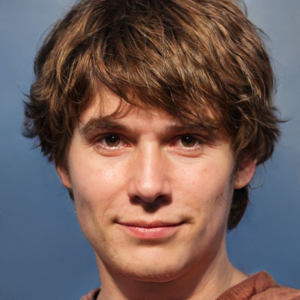

In [10]:
image2 = load_image('https://i.pinimg.com/736x/46/46/3f/46463f00c0db960a677c04f072238b82.jpg').resize((300,300))
image2

Convert the images to numpy arrays and use OpenCV to convert it to grayscale. We will also create empty image or mask similar to our source image with zeros

In [12]:
img = np.array(image1)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gray)
img2 = np.array(image2)
img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

Now, we load Face detector and Face landmarks predictor using dlib and then we will find the height, width, channels, which are required for creating empty image with zeros.

In [19]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
height, width, channels = img2.shape
img2_new_face = np.zeros((height, width, channels), dtype = np.uint8)

In [22]:
# Face 1
faces = detector(img_gray)
for face in faces:
    landmarks = predictor(img_gray, face)
    landmarks_points = []
    for n in range(68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))

    points = np.array(landmarks_points, np.int32)
    convexhull = cv.convexHull(points)
    cv.fillConvexPoly(mask, convexhull, 255)

    face_image_1 = cv.bitwise_and(img, img, mask=mask)

    # Delaunay triangulation
    rect = cv.boundingRect(convexhull)
    subdiv = cv.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, np.int32)

    indexes_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])

        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)

In [23]:
# Face 2
faces2 = detector(img2_gray)
for face in faces2:
    landmarks = predictor(img2_gray, face)
    landmarks_points2 = []
    for n in range(68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points2.append((x, y))
    
    points2 = np.array(landmarks_points2, np.int32)
    convexhull2 = cv.convexHull(points2)

In [24]:
lines_space_mask = np.zeros_like(img_gray)
lines_space_new_face = np.zeros_like(img2)

In [28]:
# Triangulation of both faces
for triangle_index in indexes_triangles:
    # Triangulation of the first face
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)


    rect1 = cv.boundingRect(triangle1)
    (x, y, w, h) = rect1
    cropped_triangle = img[y: y + h, x: x + w]
    cropped_tr1_mask = np.zeros((h, w), np.uint8)


    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

    cv.fillConvexPoly(cropped_tr1_mask, points, 255)

    # Lines space
    cv.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
    cv.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
    cv.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)
    lines_space = cv.bitwise_and(img, img, mask=lines_space_mask)

    # Triangulation of second face
    tr2_pt1 = landmarks_points2[triangle_index[0]]
    tr2_pt2 = landmarks_points2[triangle_index[1]]
    tr2_pt3 = landmarks_points2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)


    rect2 = cv.boundingRect(triangle2)
    (x, y, w, h) = rect2

    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [tr2_pt2[0] - x, tr2_pt2[1] - y],
                        [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

    cv.fillConvexPoly(cropped_tr2_mask, points2, 255)

    # Warp triangles
    points = np.float32(points)
    points2 = np.float32(points2)
    M = cv.getAffineTransform(points, points2)
    warped_triangle = cv.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    # Reconstructing destination face
    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv.cvtColor(img2_new_face_rect_area, cv.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv.threshold(img2_new_face_rect_area_gray, 1, 255, cv.THRESH_BINARY_INV)
    warped_triangle = cv.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv.add(img2_new_face_rect_area, warped_triangle)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area


In [29]:
# Face swapped (putting 1st face into 2nd face)
img2_face_mask = np.zeros_like(img2_gray)
img2_head_mask = cv.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv.bitwise_not(img2_head_mask)

In [30]:
img2_head_noface = cv.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv.add(img2_head_noface, img2_new_face)

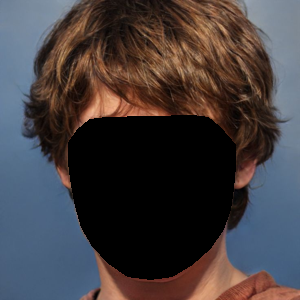

In [38]:
Image.fromarray(img2_head_noface)

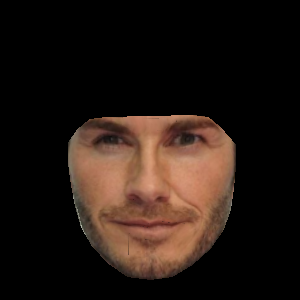

In [39]:
Image.fromarray(img2_new_face)

In [31]:
# Creating seamless clone of two faces
(x, y, w, h) = cv.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))
seamlessclone = cv.seamlessClone(result, img2, img2_head_mask, center_face2, cv.NORMAL_CLONE)

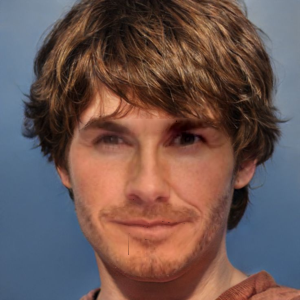

In [32]:
# Converting array to image
Image.fromarray(seamlessclone)

### Conclusion

This project may be used for Augmented Reality applications, for purposes related to art, education, and recreation.